In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_validate, KFold, train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler
import optuna

C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('dataset.csv')
#удаление дубликатов индексов
df.drop(columns=['Unnamed: 0'], inplace=True)
print("Размер датасета:", df.shape)
df.head()

Размер датасета: (114000, 20)


,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


**Расшифровка колонок:**
```plaintext
track_id     - уникальный идентификатор трека в системе Spotify
artists      - исполнитель/ли трека, через ;
album_name   - название альбома
track_name   - название трека
popularity   - популярность трека от 0 до 100, больше лучше
duration_ms  - продолжительность трека в миллисекундах 
explicit     - наличие ненормативной лексики, true или false
danceability - танцевальность, от 0 до 1, чем выше, тем танцевальнее
energy       - энергичность, от 0 до 1
key          - тональность трека по классической нотации. целочисленные значения от 0 до 11. 0 = До, 1 = до-диез/Ре-бемоль, 2 = Ре и тд
loudness     - громкость в дицебелах, в основном отриц значения
mode         - модальность, 1 - мажор, 0 - минор
speechiness	 - наличие речи, от 0 до 1, чем выше, тем больше речи
acousticness - акустичность, от 0 до 1, чем выше, тем более акустичен
instrumentalness - содержит ли трек вокал, чем ближе значение к 1.0 тем меньше вокала
liveness     - наличие в записи аудитории (аплодисменты, кашель), высокие значения указывают на высокую вероятность, что это запись с концерта
valence	     - эмоциональная окраска. Чем выше значение (ближе к 1.0), тем более позитивен трек. Чем ниже (ближе к 0.0), тем более негативен.
tempo	     - темп (скорость) трека в ударах в минуту (BPM)
time_signature - размер такта, указывающий количество долей в такте
track_genre  - музыкальный жанр трека

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114000 entries, 0 to 113999
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   track_id          114000 non-null  object 
 1   artists           113999 non-null  object 
 2   album_name        113999 non-null  object 
 3   track_name        113999 non-null  object 
 4   popularity        114000 non-null  int64  
 5   duration_ms       114000 non-null  int64  
 6   explicit          114000 non-null  bool   
 7   danceability      114000 non-null  float64
 8   energy            114000 non-null  float64
 9   key               114000 non-null  int64  
 10  loudness          114000 non-null  float64
 11  mode              114000 non-null  int64  
 12  speechiness       114000 non-null  float64
 13  acousticness      114000 non-null  float64
 14  instrumentalness  114000 non-null  float64
 15  liveness          114000 non-null  float64
 16  valence           11

Первым шагом изучим распределение нашей целевой переменной - популярности треков.

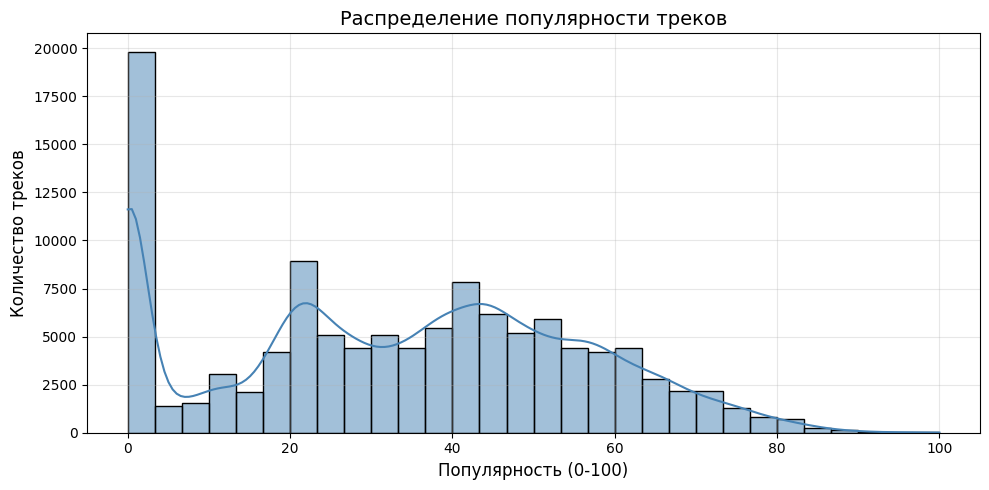

In [4]:
plt.figure(figsize=(10, 5))
sns.histplot(data=df, x='popularity', bins=30, kde=True, color='steelblue', edgecolor='black')
plt.title('Распределение популярности треков', fontsize=14)
plt.xlabel('Популярность (0-100)', fontsize=12)
plt.ylabel('Количество треков', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Мы видим огромный выброс на 0, что может свидетельствовать о сбое программы, когда собирали датасет или сиситема заполнила пропущенные значения 0. Также туда могли войти треки только выпущенные и естественно у них не сформирован рейтинг популярности.

Для того, чтобы избежать искажений, заменим нулевые значения на значения из существующего распределения

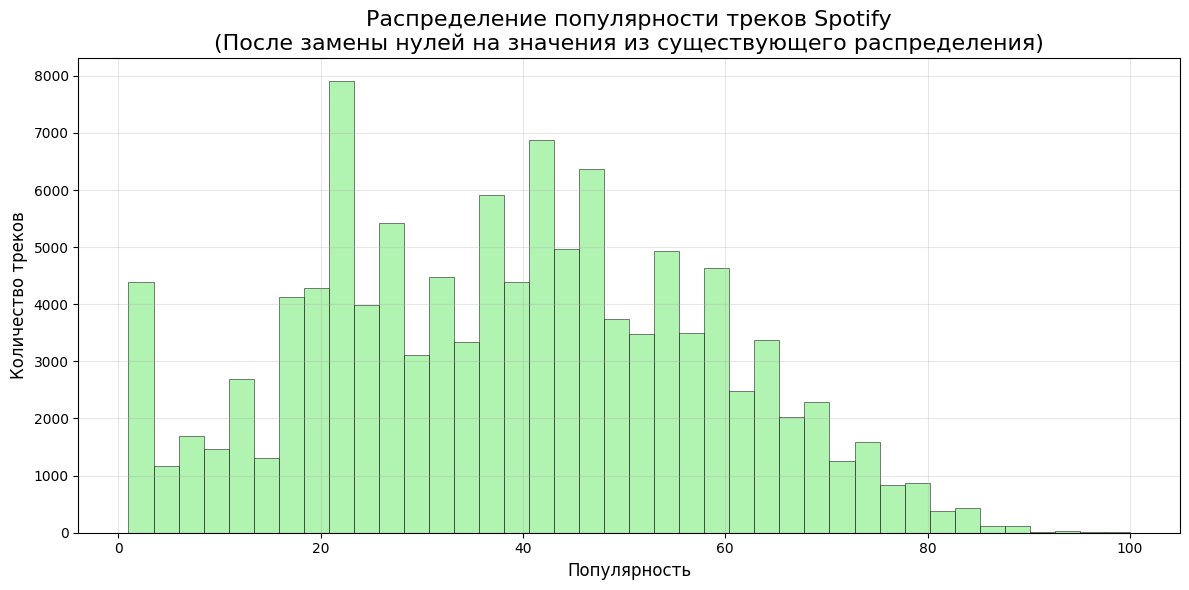

In [5]:
df_processed = df.copy()
# Находим нулевые значения
zero_mask = df_processed['popularity'] == 0
zero_count_before = zero_mask.sum()

# Берем существующие ненулевые значения популярности
non_zero_pop = df_processed[df_processed['popularity'] > 0]['popularity']
median_pop = non_zero_pop.median()
mean_pop = non_zero_pop.mean()

# берем случайные значения из существующего распределения
np.random.seed(42)
replacement_values = np.random.choice(
    non_zero_pop.values,               # из каких значений выбираем
    size=zero_count_before,            # сколько нужно значений
    replace=True                       # разрешаем повторения
)

# Заменяем нули на выбранные значения
df_processed.loc[zero_mask, 'popularity'] = replacement_values

plt.figure(figsize=(12, 6))
#Гистограмма после замены 
plt.hist(df_processed['popularity'], 
         bins=40, 
         alpha=0.7, 
         color='lightgreen',
         edgecolor='black', 
         linewidth=0.5,
         label='Все треки (после замены)')
plt.title('Распределение популярности треков Spotify\n(После замены нулей на значения из существующего распределения)', 
          fontsize=16)
plt.xlabel('Популярность', fontsize=12)
plt.ylabel('Количество треков', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

теперь скачки не такие сильные, нет искусственных пиков, что хорошо для дальнейшего анализа.

Гипотеза: Люди часто используют музыку для танцев, поэтому танцевальные треки более популярны. 

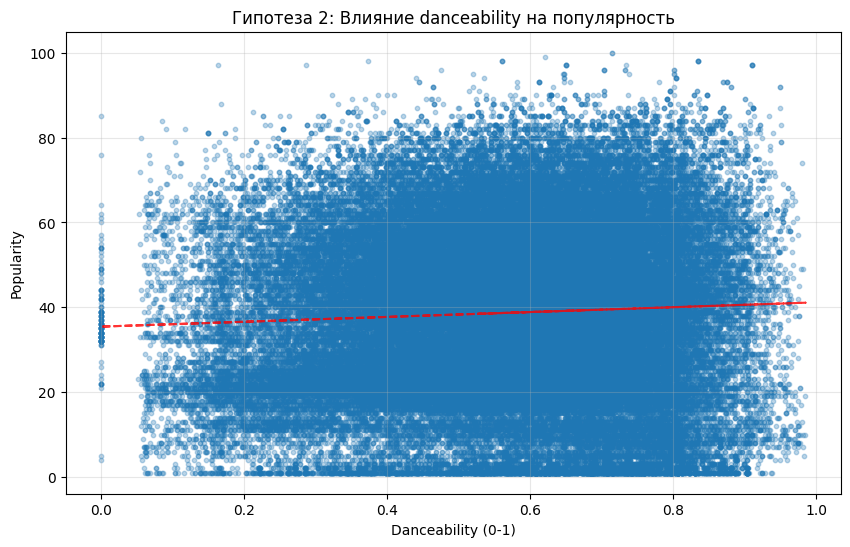

Корреляция danceability с popularity: 0.0516


In [6]:
plt.figure(figsize=(10, 6))
plt.scatter(df_processed['danceability'], df_processed['popularity'], alpha=0.3, s=10)
plt.title('Гипотеза 2: Влияние danceability на популярность')
plt.xlabel('Danceability (0-1)')
plt.ylabel('Popularity')
plt.grid(True, alpha=0.3)

# Линия тренда
z = np.polyfit(df_processed['danceability'], df_processed['popularity'], 1)
p = np.poly1d(z)
plt.plot(df_processed['danceability'], p(df_processed['danceability']), "r--", alpha=0.8)

plt.show()

corr = df_processed['danceability'].corr(df_processed['popularity'])
print(f"Корреляция danceability с popularity: {corr:.4f}")

Вывод: направление связи положительное, но связь очень слабая. Но в целом гипотеза подтвердилась. 

Гипотеза: инструментальные треки менее популярны. В современном мире преобладают вокальные треки, инструментальная музыка имеет более нишевую аудиторию 

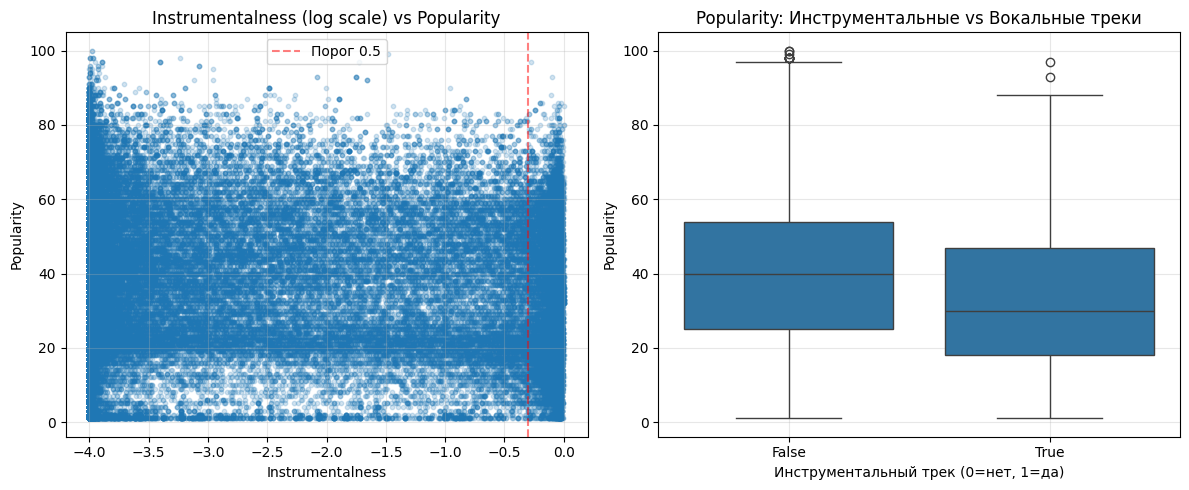

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
# Instrumentalness имеет много значений близких к 0 - используем логарифм
log_instr = np.log10(df_processed['instrumentalness'] + 0.0001)  # маленькое число чтобы избежать log(0)
plt.scatter(log_instr, df_processed['popularity'], alpha=0.2, s=10)
plt.title('Instrumentalness (log scale) vs Popularity')
plt.xlabel('Instrumentalness')
plt.ylabel('Popularity')
plt.axvline(x=np.log10(0.5), color='red', linestyle='--', alpha=0.5, label='Порог 0.5')
plt.grid(True, alpha=0.3)
plt.legend()

plt.subplot(1, 2, 2)
df_processed['is_instrumental'] = df_processed['instrumentalness'] > 0.5
sns.boxplot(data=df_processed, x='is_instrumental', y='popularity')
plt.title('Popularity: Инструментальные vs Вокальные треки')
plt.xlabel('Инструментальный трек (0=нет, 1=да)')
plt.ylabel('Popularity')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


Вывод: Гипотеза подтвердилась. Знание, что трек инструментальный, позволяет модели уверенно предсказать его низкую популярность, но не наоборот.

Гипотеза: громкие треки более популярны. Десятилетия индустрия увеличивает громкость треков. Психологический эффект - громкая музыка кажется более энергичной и захватывающей

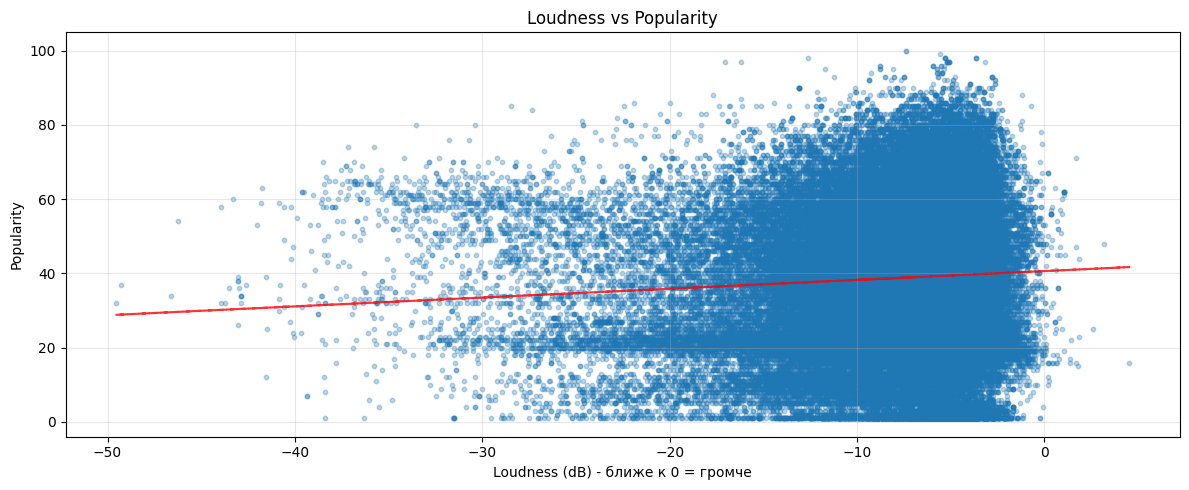


Средняя громкость по уровням популярности:
  Топ-10% популярных: -7.3 dB
  Средние 50%: -8.2 dB
  Боттом-10%: -8.8 dB


In [24]:
plt.figure(figsize=(12, 5))

plt.scatter(df_processed['loudness'], df_processed['popularity'], alpha=0.3, s=10)
plt.title('Loudness vs Popularity')
plt.xlabel('Loudness (dB) - ближе к 0 = громче')
plt.ylabel('Popularity')
plt.grid(True, alpha=0.3)

# Добавляем линию тренда
z = np.polyfit(df_processed['loudness'], df_processed['popularity'], 1)
p = np.poly1d(z)
plt.plot(df_processed['loudness'], p(df_processed['loudness']), "r--", alpha=0.8, label='Тренд')

plt.tight_layout()
plt.show()

print(f"\nСредняя громкость по уровням популярности:")
print(f"  Топ-10% популярных: {df_processed[df_processed['popularity'] >= df_processed['popularity'].quantile(0.9)]['loudness'].mean():.1f} dB")
print(f"  Средние 50%: {df_processed[(df_processed['popularity'] >= 30) & (df_processed['popularity'] <= 70)]['loudness'].mean():.1f} dB")
print(f"  Боттом-10%: {df_processed[df_processed['popularity'] <= df_processed['popularity'].quantile(0.1)]['loudness'].mean():.1f} dB")

Вывод: гипотеза подтвердилась. Подтверждает "Loudness war" - громче = коммерчески успешнее. Разница в 1.5 dB между экстремальными группами

Гипотеза: Треки в мажоре (mode=1) более популярны. Культурная традиция - западная поп-музыка исторически тяготеет к мажору. Психологическое восприятие - мажор ассоциируется с позитивом, энергией

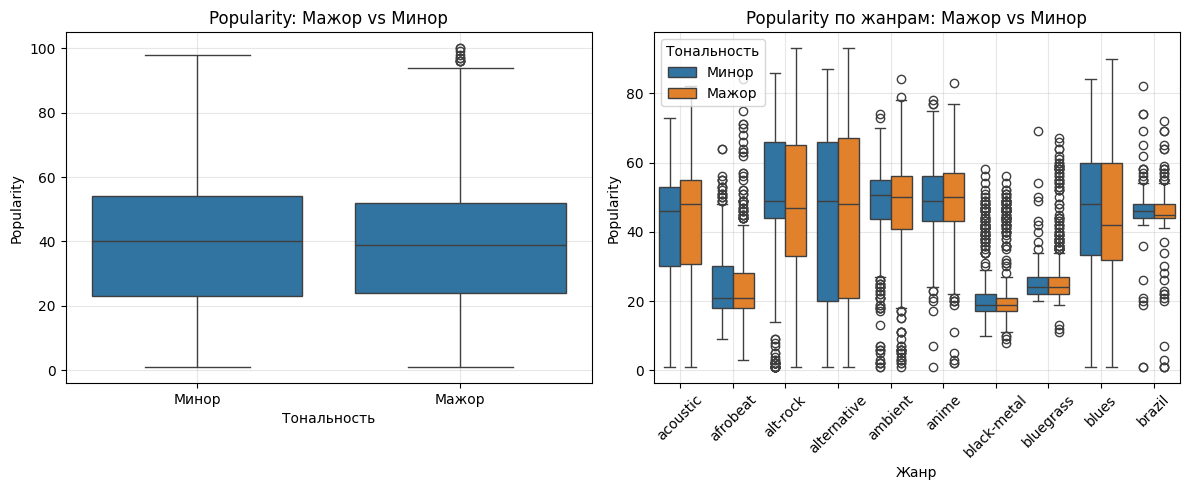


Статистика по тональности:
                mean  count
mode_name                  
Мажор      38.609774  72681
Минор      38.804569  41319

Разница в популярности: -0.19 пунктов
Соотношение мажор/минор в датасете: 1.76:1


In [13]:
# Гипотеза 4: Треки в мажоре более популярны
plt.figure(figsize=(12, 5))

# Подграфик 1: Box plot сравнение
plt.subplot(1, 2, 1)
df_processed['mode_name'] = df_processed['mode'].map({0: 'Минор', 1: 'Мажор'})
sns.boxplot(data=df_processed, x='mode_name', y='popularity')
plt.title('Popularity: Мажор vs Минор')
plt.xlabel('Тональность')
plt.ylabel('Popularity')
plt.grid(True, alpha=0.3)

# Подграфик 2: Распределение по жанрам (опционально)
plt.subplot(1, 2, 2)
# Берем топ-10 жанров по количеству треков
top_genres = df_processed['track_genre'].value_counts().head(10).index
df_top_genres = df_processed[df_processed['track_genre'].isin(top_genres)]

sns.boxplot(data=df_top_genres, x='track_genre', y='popularity', hue='mode_name')
plt.title('Popularity по жанрам: Мажор vs Минор')
plt.xlabel('Жанр')
plt.ylabel('Popularity')
plt.xticks(rotation=45)
plt.legend(title='Тональность')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


mode_stats = df_processed.groupby('mode_name')['popularity'].agg(['mean', 'count'])
print(f"\nСтатистика по тональности:")
print(mode_stats)

print(f"\nРазница в популярности: {mode_stats.loc['Мажор', 'mean'] - mode_stats.loc['Минор', 'mean']:.2f} пунктов")
print(f"Соотношение мажор/минор в датасете: {len(df_processed[df_processed['mode'] == 1]) / len(df_processed[df_processed['mode'] == 0]):.2f}:1")

**Вывод**: Гипотеха не подтвердилась, разница минимальна. Слушатели принимают оба варианта одинаково.

Гипотеза: Треки с высокой speechiness менее популярны. большинство слушателей ищут именно музыку, а не речь.

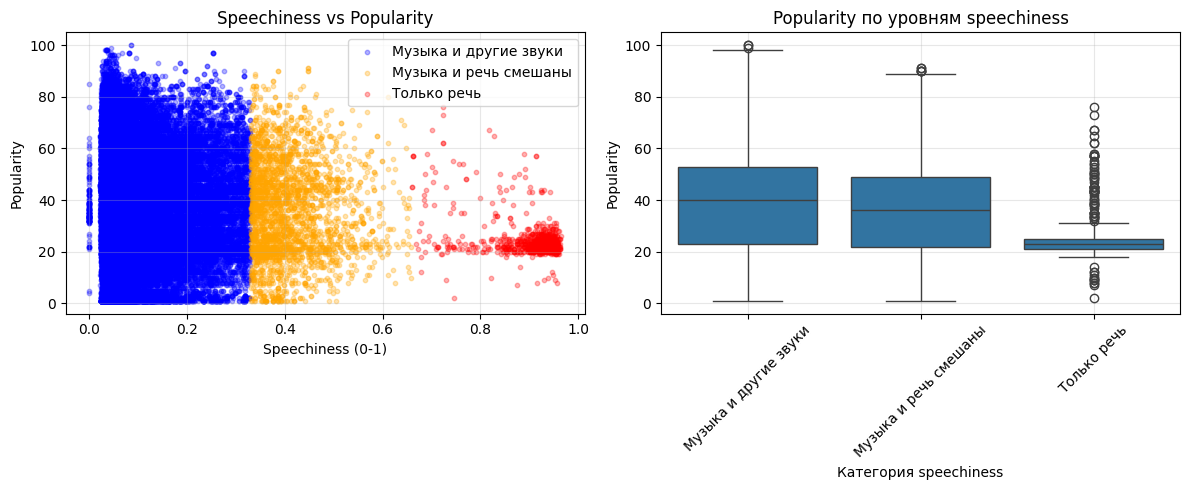


Статистика по категориям speechiness:
                            mean   count
speechiness_cat                         
Музыка и другие звуки  38.847097  110390
Музыка и речь смешаны  36.539589    2728
Только речь            24.435374     882


In [23]:
plt.figure(figsize=(12, 5))

# Подграфик 1: Scatter plot с категоризацией
plt.subplot(1, 2, 1)

# Категоризируем speechiness по типам
def speechiness_category(x):
    if x < 0.33:
        return 'Музыка и другие звуки'
    elif x < 0.66:
        return 'Музыка и речь смешаны'
    else:
        return 'Только речь'

df_processed['speechiness_cat'] = df_processed['speechiness'].apply(speechiness_category)

# Scatter с цветами по категориям
colors = {'Музыка и другие звуки': 'blue', 
          'Музыка и речь смешаны': 'orange', 
          'Только речь': 'red'}

for category, color in colors.items():
    subset = df_processed[df_processed['speechiness_cat'] == category]
    plt.scatter(subset['speechiness'], subset['popularity'], 
                alpha=0.3, s=10, color=color, label=category)

plt.title('Speechiness vs Popularity')
plt.xlabel('Speechiness (0-1)')
plt.ylabel('Popularity')
plt.legend()
plt.grid(True, alpha=0.3)

# Подграфик 2: Box plot по категориям
plt.subplot(1, 2, 2)
sns.boxplot(data=df_processed, x='speechiness_cat', y='popularity', 
            order=['Музыка и другие звуки', 'Музыка и речь смешаны', 'Только речь'])
plt.title('Popularity по уровням speechiness')
plt.xlabel('Категория speechiness')
plt.ylabel('Popularity')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nСтатистика по категориям speechiness:")
speech_stats = df_processed.groupby('speechiness_cat')['popularity'].agg(['mean', 'count'])
print(speech_stats)

**Вывод**: гипотеза подтвердилась. Рэп как исключение: Большинство рэп-треков попадает в категорию "смешанные". Речевые треки плохо путешествуют между языками

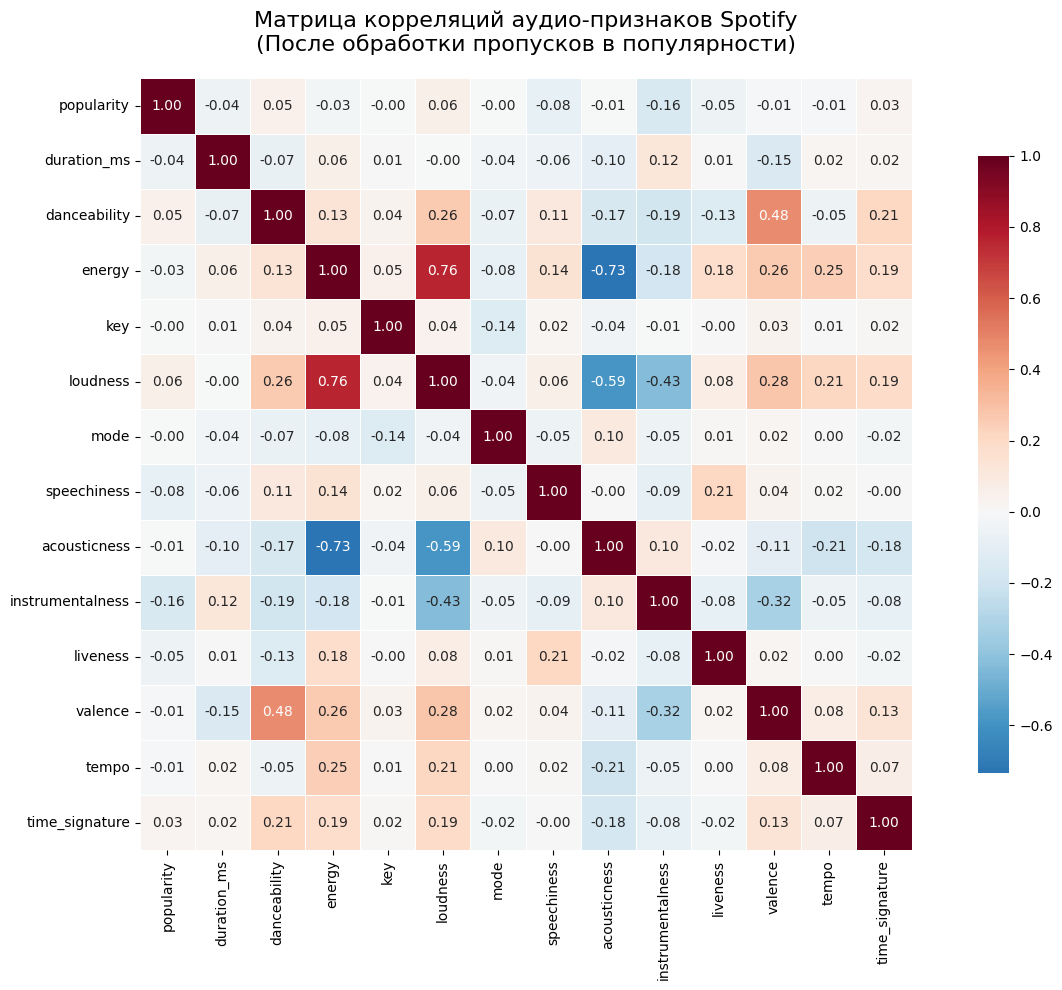

In [42]:
# Выбираем только числовые колонки для анализа
numeric_cols = df_processed.select_dtypes(include=[np.number]).columns.tolist()

# Создаем матрицу корреляций
corr_matrix = df_processed[numeric_cols].corr()

plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, 
            annot=True, 
            fmt='.2f', 
            cmap='RdBu_r', 
            center=0,
            square=True,
            linewidths=0.5,
            cbar_kws={"shrink": 0.8})

plt.title('Матрица корреляций аудио-признаков Spotify\n(После обработки пропусков в популярности)', 
          fontsize=16, pad=20)
plt.tight_layout()
plt.show()

**Вывод:**  Громкие треки воспринимаются как более энергичные (корр 0.76), а так же танцевальные треки имеют более позитивную эмоциональную окраску (корр 0.48). В современной музыкальной индустрии громкость часто достигается за счет компрессии и лимитинга, что создает ощущение постоянной энергии и плотности звучания. Психоакустически, громкие треки действительно воспринимаются как более энергичные, а музыка для танцев традиционно ассоциируется с положительными эмоциями, весельем и праздником. 

Наибольша отрицательная корреляция у энергии и акустичности (-0.73), у громкости и акустичности (-0.59). Акустические инструменты (гитара, фортепиано, струнные) имеют естественные динамические ограничения и не могут достичь той же плотности и интенсивности звучания, что и электронные инструменты с обработкой. Кроме того, акустическая музыка часто ассоциируется со спокойными жанрами. Так же громкие треки чаще содержат вокал (корр -0.43), В популярной музыке вокал является центральным элементом, и продюсеры часто выдвигают его на передний план, делая громче.

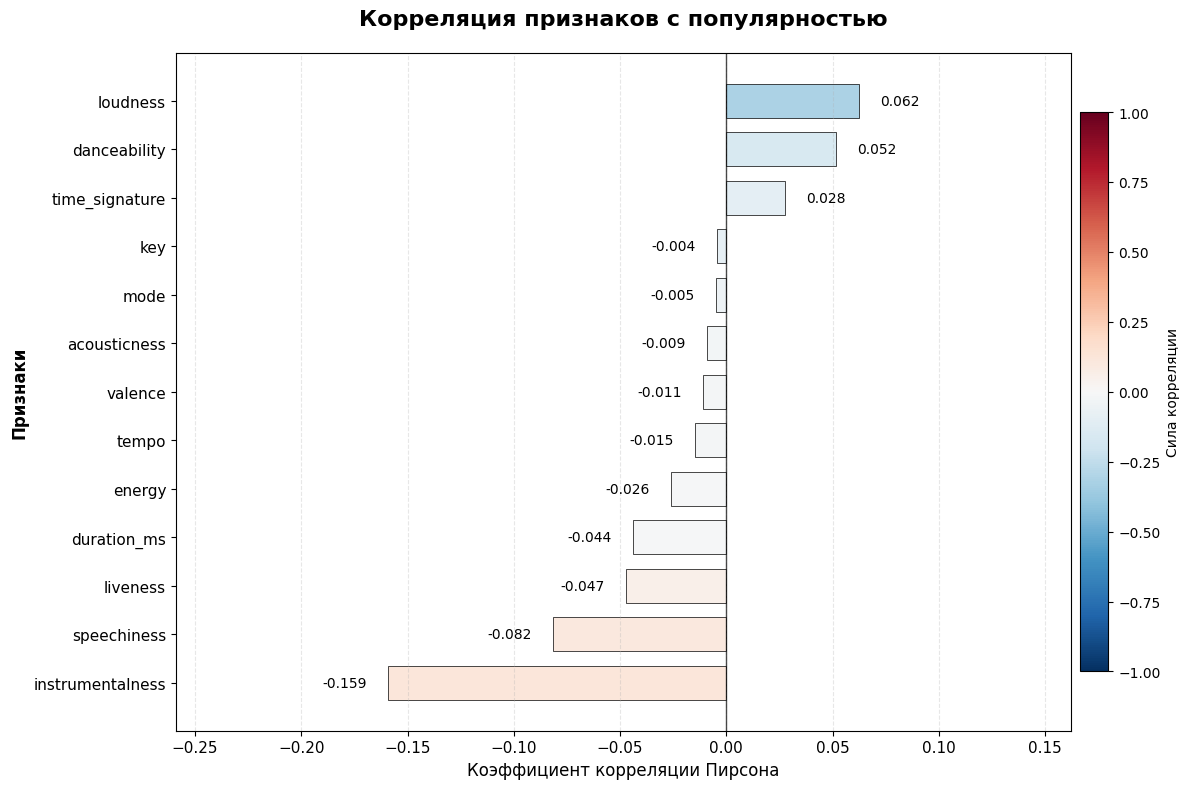

In [43]:
# Отдельно смотрим корреляции с таргетом
target_corr = corr_matrix['popularity'].sort_values(ascending=False)

# Убираем сам popularity из списка
target_corr = target_corr.drop('popularity')
plt.figure(figsize=(12, 8))

colors = plt.cm.RdBu_r((target_corr.values + 0.5) / 1.0)
target_corr_sorted = target_corr.sort_values()

bars = plt.barh(range(len(target_corr_sorted)), 
                target_corr_sorted.values, 
                color=colors, 
                edgecolor='black', 
                linewidth=0.5,
                height=0.7)

plt.yticks(range(len(target_corr_sorted)), target_corr_sorted.index, fontsize=11)
plt.xticks(fontsize=11)

# Вертикальная линия на 0
plt.axvline(x=0, color='black', linewidth=1, linestyle='-', alpha=0.7)

for i, (bar, value) in enumerate(zip(bars, target_corr_sorted.values)):
    # Выбираем положение текста в зависимости от знака
    if value >= 0:
        text_x = value + 0.01  # Справа от бара
        ha = 'left'
        color = 'darkgreen' if value > 0.3 else 'black'
    else:
        text_x = value - 0.01  # Слева от бара
        ha = 'right'
        color = 'darkred' if value < -0.3 else 'black'
    
    plt.text(text_x, 
             bar.get_y() + bar.get_height()/2,
             f'{value:.3f}', 
             ha=ha,
             va='center')

# Ограничиваем оси, чтобы текст не выходил за границы
plt.xlim(min(target_corr_sorted.values) - 0.1, 
         max(target_corr_sorted.values) + 0.1)

# Добавляем сетку
plt.grid(True, alpha=0.3, axis='x', linestyle='--')

# Подписи и заголовок
plt.xlabel('Коэффициент корреляции Пирсона', fontsize=12)
plt.ylabel('Признаки', fontsize=12, fontweight='bold')
plt.title('Корреляция признаков с популярностью', 
          fontsize=16, fontweight='bold', pad=20)

# Добавляем цветовую шкалу для справки
sm = plt.cm.ScalarMappable(cmap='RdBu_r', norm=plt.Normalize(vmin=-1, vmax=1))
sm.set_array([])
cbar = plt.colorbar(sm, ax=plt.gca(), orientation='vertical', 
                    fraction=0.03, pad=0.01)
cbar.set_label('Сила корреляции', fontsize=10)
plt.tight_layout()
plt.show()   


**Вывод:** Ни один признак не имеет корреляции с popularity выше 0.16. Это указывает на то, что популярность - сложный феномен, зависящий не только от аудио-характеристик, но и от маркетинга, времени релиза, известности исполнителя, трендов и культурного контекста.

**Feature Engineering**

In [44]:
# Удаляем строки с пропусками в текстовых полях
df = df_processed.dropna(subset=['artists', 'album_name', 'track_name']).copy()

df['explicit'] = df['explicit'].astype(int)
new_columns = []

# Структурные признаки
df['duration_min'] = df['duration_ms'] / 60000  # длительность в минутах
new_columns.append('duration_min')

df['is_acoustic'] = (df['acousticness'] > 0.5).astype(int)  # акустическая ли песня
new_columns.append('is_acoustic')


# Признаки из текста
df['num_artists'] = df['artists'].apply(lambda x: len(str(x).split(';')))
new_columns.append('num_artists')

df['is_collab'] = (df['num_artists'] > 1).astype(int)
new_columns.append('is_collab')

df['has_feat'] = df['track_name'].str.contains('feat|ft\.|with', case=False, na=False).astype(int)
new_columns.append('has_feat')

df['is_remix'] = df['track_name'].str.contains('remix|rmx', case=False, na=False).astype(int)
new_columns.append('is_remix')


print(f"\nСоздано новых признаков: {len(new_columns)}")
print("Новые признаки:", new_columns)

# Проверяем, что все новые колонки существуют
existing_new_cols = [col for col in new_columns if col in df.columns]

# Добавляем popularity для корреляции
cols_for_corr = existing_new_cols + ['popularity']

# Вычисляем корреляцию только для новых признаков
corr_matrix_new = df[cols_for_corr].corr()
corr_with_target_new = corr_matrix_new['popularity'].drop('popularity').sort_values(ascending=False)

print(f"\n Корреляция новых признаков с popularity:")
for i, (feature, corr) in enumerate(corr_with_target_new.items(), 1):
    print(f"{i:2d}. {feature:25s}: {corr:7.4f}")


Создано новых признаков: 6
Новые признаки: ['duration_min', 'is_acoustic', 'num_artists', 'is_collab', 'has_feat', 'is_remix']

 Корреляция новых признаков с popularity:
 1. has_feat                 :  0.0998
 2. is_collab                :  0.0451
 3. num_artists              :  0.0292
 4. is_remix                 : -0.0207
 5. is_acoustic              : -0.0240
 6. duration_min             : -0.0439


**Вывод**: Треки с участием других артистов (feat, ft., with) имеют значительно большую популярность. Коллаборации (треки с несколькими артистами) популярнее соло-треков. Чем больше артистов участвует в треке, тем он популярнее. 

Подготовка данных

In [57]:
features = [
    'duration_ms', 'danceability', 'energy', 'key', 'loudness',
    'mode', 'speechiness', 'acousticness', 'instrumentalness',
    'liveness', 'valence', 'tempo', 'time_signature', 'explicit', 
    'duration_min', 'is_acoustic', 'num_artists', 
    'is_collab', 'has_feat', 'is_remix'
]


# Создаем X и y
X = df[features]
y = df['popularity']

# Разделяем на train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

**Feature Importances** и **простая модель**

In [58]:
# Обучение Random Forest
rf_model = RandomForestRegressor(
    n_estimators=100,
    random_state=42,
    n_jobs=-1,
    max_depth=10,
    min_samples_split=5
)

rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

print("метрики:")
print(f"MAE:  {mae:.4f}")
print(f"MSE:  {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R2:   {r2:.4f}")
print(f"MAPE: {mape:.4f}")

метрики:
MAE:  14.5166
MSE:  323.5112
RMSE: 17.9864
R2:   0.1261
MAPE: 1.6735


ТОП-15 важных признаков:
 1. instrumentalness         : 0.2027
 2. acousticness             : 0.1126
 3. valence                  : 0.0970
 4. speechiness              : 0.0963
 5. energy                   : 0.0768
 6. danceability             : 0.0696
 7. loudness                 : 0.0664
 8. duration_ms              : 0.0527
 9. has_feat                 : 0.0522
10. duration_min             : 0.0514
11. tempo                    : 0.0457
12. liveness                 : 0.0360
13. key                      : 0.0100
14. explicit                 : 0.0100
15. num_artists              : 0.0074


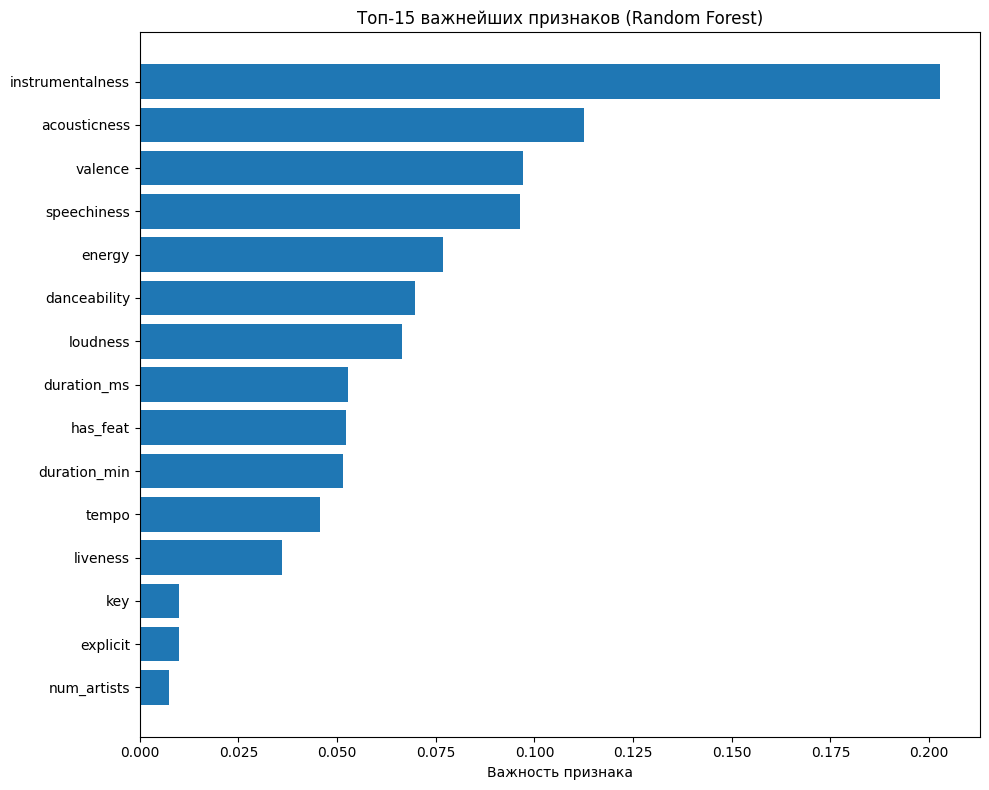

In [59]:
# Feature Importances
importances = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': importances
}).sort_values('importance', ascending=False)

print("ТОП-15 важных признаков:")
for i, row in enumerate(feature_importance_df.head(15).itertuples(), 1):
    print(f"{i:2d}. {row.feature:25s}: {row.importance:.4f}")

plt.figure(figsize=(10, 8))
top_features = feature_importance_df.head(15)

plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Важность признака')
plt.title('Топ-15 важнейших признаков (Random Forest)')
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()

**вывод** has_feat - единственный текстовый признак в топ-10, подтверждает нашу гипотезу. Инструментальные треки сильно отличаются по популярности, полностью инструментальные композиции имеют принципиально другую аудиторию и паттерны популярности по сравнению с вокальными треками. Акустичность - второй по важности фактор, что отражает разделение между электронной/обработанной и живой/акустической музыкой, которые привлекают разные сегменты слушателей. Настроение трека тоже влияет на популярность, подтверждая, что "радостные" треки чаще набирают популярность.

При этом другие созданные нами признаки (is_collab, is_remix, is_acoustic) не вошли в топ-15, что говорит о том, что их информацию модель получает из других, более сильных признаков.

**Эксперименты с моделями**

In [60]:
lasso = Lasso(alpha=0.01, random_state=42, max_iter=10000)

kfold = KFold(n_splits=5, shuffle=True, random_state=42)

cv_results = cross_validate(
    lasso, X, y, cv=kfold,
    scoring=['neg_mean_absolute_error', 'neg_mean_squared_error', 'r2', 'neg_mean_absolute_percentage_error'],
    return_train_score=False
)

# Метрики по фолдам
for fold in range(5):
    mae = -cv_results['test_neg_mean_absolute_error'][fold]
    mse = -cv_results['test_neg_mean_squared_error'][fold]
    rmse = np.sqrt(mse)
    r2 = cv_results['test_r2'][fold]
    mape = -cv_results['test_neg_mean_absolute_percentage_error'][fold]
    
    print(f"\nФолд {fold+1}:")
    print(f"  MAE:  {mae:.4f}")
    print(f"  MSE:  {mse:.4f}")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  R2:   {r2:.4f}")
    print(f"  MAPE: {mape:.4f}")

# Средние метрики
mae_mean = -cv_results['test_neg_mean_absolute_error'].mean()
mse_mean = -cv_results['test_neg_mean_squared_error'].mean()
r2_mean = cv_results['test_r2'].mean()
mape_mean = -cv_results['test_neg_mean_absolute_percentage_error'].mean()

print("Lasso - cредние метрики (5 фолдлв):")
print(f"MAE:  {mae_mean:.4f}")
print(f"MSE:  {mse_mean:.4f}")
print(f"RMSE: {np.sqrt(mse_mean):.4f}")
print(f"R2:   {r2_mean:.4f}")
print(f"MAPE: {mape_mean:.4f}")


Фолд 1:
  MAE:  15.3074
  MSE:  350.4056
  RMSE: 18.7191
  R2:   0.0535
  MAPE: 1.7476

Фолд 2:
  MAE:  15.2411
  MSE:  347.6123
  RMSE: 18.6444
  R2:   0.0583
  MAPE: 1.6236

Фолд 3:
  MAE:  15.3084
  MSE:  348.9338
  RMSE: 18.6798
  R2:   0.0579
  MAPE: 1.6468

Фолд 4:
  MAE:  15.2856
  MSE:  348.3449
  RMSE: 18.6640
  R2:   0.0565
  MAPE: 1.7012

Фолд 5:
  MAE:  15.1511
  MSE:  344.3035
  RMSE: 18.5554
  R2:   0.0643
  MAPE: 1.6063
Lasso - cредние метрики (5 фолдлв):
MAE:  15.2587
MSE:  347.9200
RMSE: 18.6526
R2:   0.0581
MAPE: 1.6651


In [61]:
# Создаем модель Decision Tree
dt_model = DecisionTreeRegressor(
    max_depth=10,        
    random_state=42
)

# Кросс-валидация (5 фолдов)
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

cv_results = cross_validate(
    dt_model, 
    X, y,
    cv=kfold,
    scoring=['neg_mean_absolute_error', 'neg_mean_squared_error', 'r2', 'neg_mean_absolute_percentage_error'],
    return_train_score=False
)

# Метрики по фолдам
for fold in range(5):
    mae = -cv_results['test_neg_mean_absolute_error'][fold]
    mse = -cv_results['test_neg_mean_squared_error'][fold]
    rmse = np.sqrt(mse)
    r2 = cv_results['test_r2'][fold]
    mape = -cv_results['test_neg_mean_absolute_percentage_error'][fold]
    
    print(f"\nФолд {fold+1}:")
    print(f"  MAE:  {mae:.4f}")
    print(f"  MSE:  {mse:.4f}")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  R2:   {r2:.4f}")
    print(f"  MAPE: {mape:.4f}")

# Средние метрики
print("\n DecisionTreeRegressor - cредние метрики:")

mean_mae = -cv_results['test_neg_mean_absolute_error'].mean()
mean_mse = -cv_results['test_neg_mean_squared_error'].mean()
mean_rmse = np.sqrt(mean_mse)
mean_r2 = cv_results['test_r2'].mean()
mean_mape = -cv_results['test_neg_mean_absolute_percentage_error'].mean()

print(f"MAE:  {mean_mae:.4f}")
print(f"MSE:  {mean_mse:.4f}")
print(f"RMSE: {mean_rmse:.4f}")
print(f"R2:   {mean_r2:.4f}")
print(f"MAPE: {mean_mape:.4f}")


Фолд 1:
  MAE:  14.7289
  MSE:  338.4668
  RMSE: 18.3975
  R2:   0.0858
  MAPE: 1.6845

Фолд 2:
  MAE:  14.7100
  MSE:  337.8900
  RMSE: 18.3818
  R2:   0.0846
  MAPE: 1.5689

Фолд 3:
  MAE:  14.7553
  MSE:  338.1553
  RMSE: 18.3890
  R2:   0.0870
  MAPE: 1.5843

Фолд 4:
  MAE:  14.7230
  MSE:  336.7431
  RMSE: 18.3506
  R2:   0.0879
  MAPE: 1.6472

Фолд 5:
  MAE:  14.6788
  MSE:  335.7434
  RMSE: 18.3233
  R2:   0.0876
  MAPE: 1.5521

 DecisionTreeRegressor - cредние метрики:
MAE:  14.7192
MSE:  337.3997
RMSE: 18.3684
R2:   0.0866
MAPE: 1.6074


In [62]:
# Создаем модель Gradient Boosting
gb_model = GradientBoostingRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=3,
    subsample=0.9,
    random_state=42
)

# Кросс-валидация (5 фолдов)
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

cv_results = cross_validate(
    gb_model, 
    X, y,
    cv=kfold,
    scoring=['neg_mean_absolute_error', 'neg_mean_squared_error', 'r2', 'neg_mean_absolute_percentage_error'],
    return_train_score=False
)

# Метрики по фолдам
print("\nМЕТРИКИ ПО ФОЛДАМ:")
for fold in range(5):
    mae = -cv_results['test_neg_mean_absolute_error'][fold]
    mse = -cv_results['test_neg_mean_squared_error'][fold]
    rmse = np.sqrt(mse)
    r2 = cv_results['test_r2'][fold]
    mape = -cv_results['test_neg_mean_absolute_percentage_error'][fold]
    
    print(f"\nФолд {fold+1}:")
    print(f"  MAE:  {mae:.4f}")
    print(f"  MSE:  {mse:.4f}")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  R2:   {r2:.4f}")
    print(f"  MAPE: {mape:.4f}")

# Средние метрики
print("\n GradientBoostingRegressor - cредние метрики:")

mean_mae = -cv_results['test_neg_mean_absolute_error'].mean()
mean_mse = -cv_results['test_neg_mean_squared_error'].mean()
mean_rmse = np.sqrt(mean_mse)
mean_r2 = cv_results['test_r2'].mean()
mean_mape = -cv_results['test_neg_mean_absolute_percentage_error'].mean()

print(f"MAE:  {mean_mae:.4f}")
print(f"MSE:  {mean_mse:.4f}")
print(f"RMSE: {mean_rmse:.4f}")
print(f"R2:   {mean_r2:.4f}")
print(f"MAPE: {mean_mape:.4f}")


МЕТРИКИ ПО ФОЛДАМ:

Фолд 1:
  MAE:  14.6554
  MSE:  328.3424
  RMSE: 18.1202
  R2:   0.1131
  MAPE: 1.6934

Фолд 2:
  MAE:  14.5918
  MSE:  326.5275
  RMSE: 18.0701
  R2:   0.1154
  MAPE: 1.5741

Фолд 3:
  MAE:  14.6640
  MSE:  328.3323
  RMSE: 18.1199
  R2:   0.1136
  MAPE: 1.5995

Фолд 4:
  MAE:  14.6031
  MSE:  325.9885
  RMSE: 18.0552
  R2:   0.1170
  MAPE: 1.6496

Фолд 5:
  MAE:  14.5064
  MSE:  322.5370
  RMSE: 17.9593
  R2:   0.1234
  MAPE: 1.5597

 GradientBoostingRegressor - cредние метрики:
MAE:  14.6042
MSE:  326.3455
RMSE: 18.0650
R2:   0.1165
MAPE: 1.6153


In [63]:
# Масштабируем данные (нейросети чувствительны к масштабу)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Создаем нейронную сеть
mlp_model = MLPRegressor(
    hidden_layer_sizes=(100, 50),  # 2 скрытых слоя: 100 и 50 нейронов
    activation='relu',
    solver='adam',
    batch_size=32,
    max_iter=300,
    random_state=42,
    early_stopping=True,
)

# Кросс-валидация (5 фолдов)
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

cv_results = cross_validate(
    mlp_model, 
    X_scaled, y,
    cv=kfold,
    scoring=['neg_mean_absolute_error', 'neg_mean_squared_error', 'r2', 'neg_mean_absolute_percentage_error'],
    return_train_score=False
)

# Метрики по фолдам
for fold in range(5):
    mae = -cv_results['test_neg_mean_absolute_error'][fold]
    mse = -cv_results['test_neg_mean_squared_error'][fold]
    rmse = np.sqrt(mse)
    r2 = cv_results['test_r2'][fold]
    mape = -cv_results['test_neg_mean_absolute_percentage_error'][fold]
    
    print(f"\nФолд {fold+1}:")
    print(f"  MAE:  {mae:.4f}")
    print(f"  MSE:  {mse:.4f}")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  R2:   {r2:.4f}")
    print(f"  MAPE: {mape:.4f}")

# Средние метрики
mean_mae = -cv_results['test_neg_mean_absolute_error'].mean()
mean_mse = -cv_results['test_neg_mean_squared_error'].mean()
mean_rmse = np.sqrt(mean_mse)
mean_r2 = cv_results['test_r2'].mean()
mean_mape = -cv_results['test_neg_mean_absolute_percentage_error'].mean()

print("\n MLPRegressor - cредние метрики:")
print(f"MAE:  {mean_mae:.4f}")
print(f"MSE:  {mean_mse:.4f}")
print(f"RMSE: {mean_rmse:.4f}")
print(f"R2:   {mean_r2:.4f}")
print(f"MAPE: {mean_mape:.4f}")


Фолд 1:
  MAE:  14.3355
  MSE:  321.6322
  RMSE: 17.9341
  R2:   0.1312
  MAPE: 1.5917

Фолд 2:
  MAE:  14.3147
  MSE:  319.7312
  RMSE: 17.8810
  R2:   0.1338
  MAPE: 1.5365

Фолд 3:
  MAE:  14.3934
  MSE:  321.8253
  RMSE: 17.9395
  R2:   0.1311
  MAPE: 1.5582

Фолд 4:
  MAE:  14.4385
  MSE:  322.2830
  RMSE: 17.9522
  R2:   0.1270
  MAPE: 1.6227

Фолд 5:
  MAE:  14.2310
  MSE:  316.8650
  RMSE: 17.8007
  R2:   0.1389
  MAPE: 1.4889

 MLPRegressor - cредние метрики:
MAE:  14.3426
MSE:  320.4673
RMSE: 17.9016
R2:   0.1324
MAPE: 1.5596


По итогам победила модель MLPRegressor.

Нейронная сеть (MLP) показала лучший результат по всем метрикам, что необычно для табличных данных

Все модели имеют низкий R2 (0.06-0.13) - популярность Spotify плохо предсказывается только по аудио-признакам

MAE ~14.3-15.3 пунктов - средняя ошибка предсказания популярности

Линейные модели (Lasso) провалились - данные имеют сложные нелинейные зависимости